# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os

%matplotlib inline

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Lane Finding Pipeline

In [2]:
def process_image_core(image_input, should_print):
    if should_print:
        plt.figure().add_subplot(1,1,1).set_title('Original image')
        plt.imshow(image_input)
    
    h = image_input.shape[0]
    w = image_input.shape[1]
    
    # Filter yellow to white colors and only use them for processing
    mask = cv2.inRange(image_input, np.array([220, 170, 0]), np.array([255, 255, 255]))
    image = cv2.bitwise_and(image_input, image_input, mask = mask)

    # Define a kernel size for Gaussian smoothing
    kernel_size = 5

    # Define our parameters for Canny
    low_threshold = 50
    high_threshold = 150

    # Define the Hough transform parameters
    rho = 1 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 5     # minimum number of votes (intersections in Hough grid cell)
    min_line_length = 20 # minimum number of pixels making up a line
    max_line_gap = 50    # maximum gap in pixels between connectable line segments

    gray = cv2.cvtColor(image,cv2.COLOR_RGB2GRAY)
    
    # Apply Gaussian smoothing
    blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)
    
    # Apply Canny
    edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
    
    # Create a four sided polygon mask image using cv2.fillPoly()
    ignore_mask_color = 255   
    top_y = int(6 / 10 * h)
    vertices = np.array([[(5/100*w,h), (46/100*w, top_y), (54/100*w, top_y), (95/100*w,h)]], dtype=np.int32)
    mask = np.zeros_like(edges)
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    # Apply mask
    masked_edges = cv2.bitwise_and(edges, mask)
     
    # Make a blank the same size as our image to draw on
    line_image = np.copy(image)*0 # creating a blank to draw lines on

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
    lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]), min_line_length, max_line_gap)

    # Iterate over the output "lines" and depending on the slope separate line segments into left and right lanes
    # with ignoring lines that are out of region of interest (like right-sloped line segment in the left half of the image)
    l_lane = []
    r_lane = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            k = (y2 - y1) / (x2 - x1)
            if k < 0:
                if  k < -0.5 and x1 < w / 2 and x2 < w / 2:
                    l_lane.append([x1,y1])
                    l_lane.append([x2,y2])
                    # Draw line segment
                    #for x1,y1,x2,y2 in line:
                    #    cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
            else:
                if k > 0.5 and x1 > w / 2 and x2 > w / 2:
                    r_lane.append([x1,y1])
                    r_lane.append([x2,y2])
                    # Draw line segment
                    #for x1,y1,x2,y2 in line:
                    #    cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)
                
    
    # Fit left line segments with single line : y = l_k * x + l_b
    l_lane = np.array(l_lane)
    if l_lane is not None and l_lane.size > 0:
        l_lane_x = l_lane[:,0]
        l_lane_y = l_lane[:,1]
        
        l_A = np.vstack([l_lane_x, np.ones(len(l_lane_x))]).T
        l_k, l_b = np.linalg.lstsq(l_A, l_lane_y)[0]
        
        cv2.line(line_image,(int((h - l_b) / l_k), h), (int((top_y - l_b) / l_k), top_y), (0,255,0), 10)
    
    # Fit right line segments with single line : y = r_k * x + r_b
    r_lane = np.array(r_lane)
    if r_lane is not None and r_lane.size > 0:
        r_lane_x = r_lane[:,0]
        r_lane_y = r_lane[:,1]
        
        r_A = np.vstack([r_lane_x, np.ones(len(r_lane_x))]).T
        r_k, r_b = np.linalg.lstsq(r_A, r_lane_y)[0]
        
        cv2.line(line_image,(int((h - r_b) / r_k), h), (int((top_y - r_b) / r_k), top_y), (255,0,0), 10)
        
    if should_print:
        color_edges = np.dstack((edges, edges, edges))

        lines_edges = cv2.add(color_edges, line_image)

        plt.figure().add_subplot(1,1,1).set_title('Processed gray image')
        plt.imshow(lines_edges)

    # For final image we combine the original image with lane lines - left (green) and right (red)
    final_image = cv2.add(image_input, line_image)
    
    if should_print:
        plt.figure().add_subplot(1,1,1).set_title('Processed image')
        plt.imshow(final_image)
    
        plt.show()

    return final_image

## Pipeline on test images

test_images/solidWhiteCurve.jpg


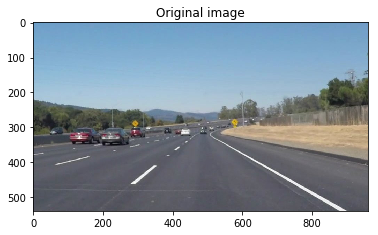

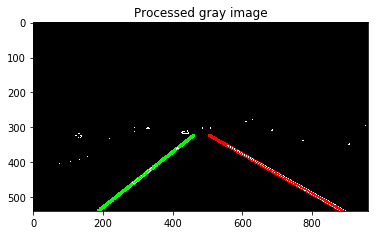

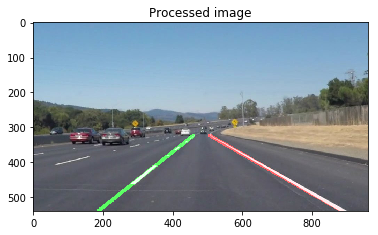

test_images/solidWhiteRight.jpg


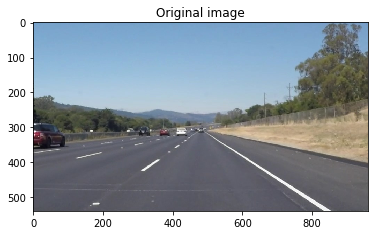

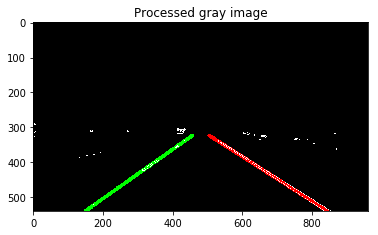

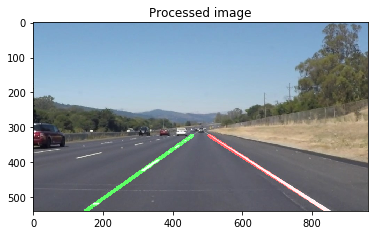

test_images/solidYellowCurve.jpg


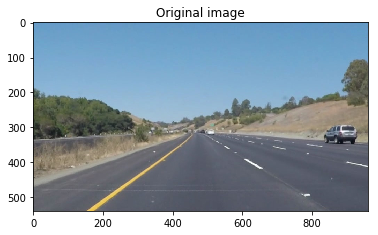

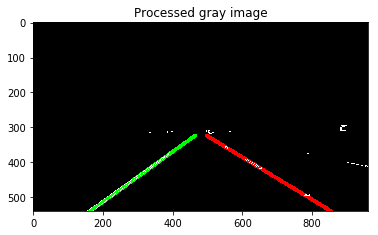

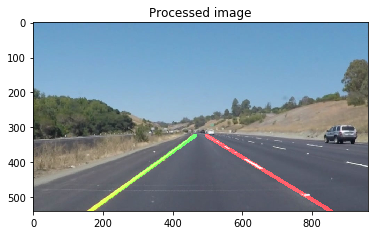

test_images/solidYellowCurve2.jpg


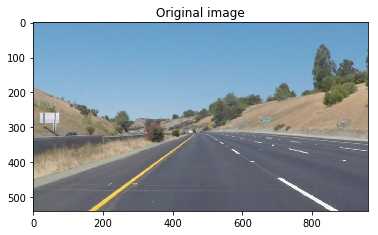

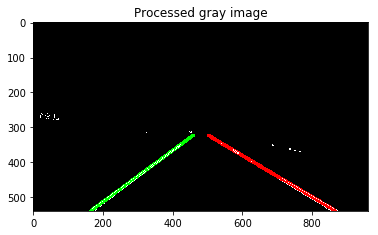

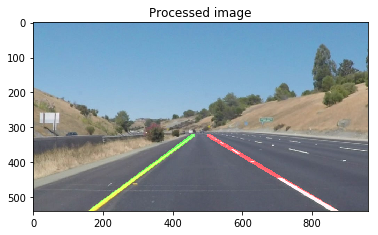

test_images/solidYellowLeft.jpg


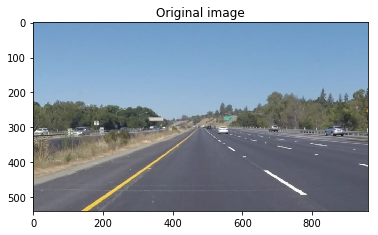

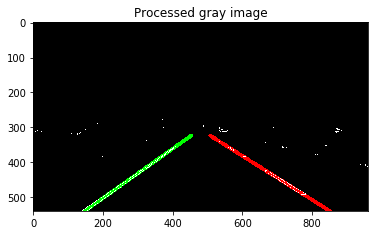

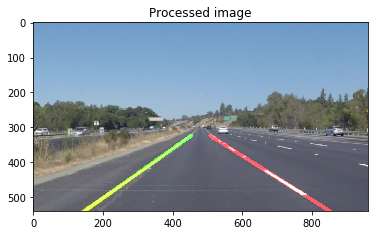

test_images/whiteCarLaneSwitch.jpg


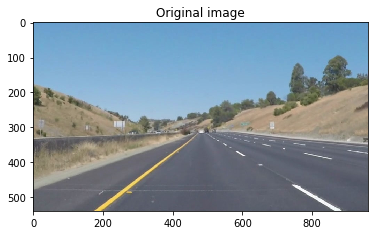

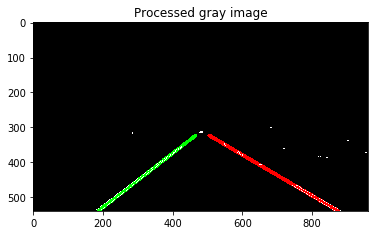

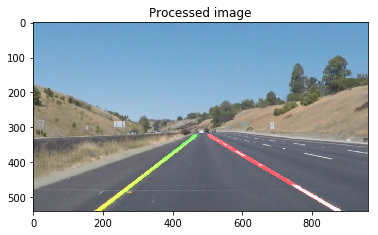

In [3]:
image_names = ['test_images/' + image_name for image_name in os.listdir("test_images/")]
image_count = len(image_names)

for i in range(image_count):
    image_name = image_names[i]
    print(image_name)
    
    image = mpimg.imread(image_name)
    
    process_image_core(image, True)

In [4]:
def process_image(image):
    return process_image_core(image, False)

def process_video(video_input, video_output):
    clip_input = VideoFileClip(video_input)
    clip_output = clip_input.fl_image(process_image)
    %time clip_output.write_videofile(video_output, audio=False)

## Pipeline on test videos

In [5]:
videos = ['test_videos/solidWhiteRight', 'test_videos/solidYellowLeft', 'test_videos/challenge']

for video in videos:
    process_video(video + '.mp4', video + '_processed.mp4')

[MoviePy] >>>> Building video test_videos/solidWhiteRight_processed.mp4
[MoviePy] Writing video test_videos/solidWhiteRight_processed.mp4


100%|█████████▉| 221/222 [00:06<00:00, 35.32it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos/solidWhiteRight_processed.mp4 

Wall time: 6.95 s
[MoviePy] >>>> Building video test_videos/solidYellowLeft_processed.mp4
[MoviePy] Writing video test_videos/solidYellowLeft_processed.mp4


100%|█████████▉| 681/682 [00:19<00:00, 34.74it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos/solidYellowLeft_processed.mp4 

Wall time: 20.3 s
[MoviePy] >>>> Building video test_videos/challenge_processed.mp4
[MoviePy] Writing video test_videos/challenge_processed.mp4


100%|██████████| 251/251 [00:12<00:00, 20.38it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos/challenge_processed.mp4 

Wall time: 14.1 s


In [6]:
HTML("""<video width="960" height="540" controls><source src="{0}"></video>""".format(videos[0] + '_processed.mp4'))

In [7]:
HTML("""<video width="960" height="540" controls><source src="{0}"></video>""".format(videos[1] + '_processed.mp4'))

In [8]:
HTML("""<video width="960" height="540" controls><source src="{0}"></video>""".format(videos[2] + '_processed.mp4'))